# CS 109A/AC 209A/STAT 121A Data Science: Airbnb Project
## Further Exploration of Seasonality
**Harvard University**  
**Fall 2016**  
**Team**: Stephen Camera-Murray, Himani Garg, and Vijay Thangella  
**TF**: Christine Hwang  
  
**Due Date: ** Wednesday, November 5th, 2016 at 11:59pm

### III. Further Exploration of Seasonality

Import libraries

In [1]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from sklearn.linear_model import LogisticRegression
import wordcloud
import pandasql

# suppress warnings
warnings.filterwarnings ( 'ignore' )
%matplotlib inline

#### Load the cleansed data

We begin by loading the listings dataset we saved after cleansing from milestone #4:  
- cleansed_listings.csv.gz - the New York City Airbnb listing data from January 2015 (cleansed)
- calendar.csv.gz - listing prices for specific dates-- to be analyzed for seasonality

In [2]:
# load listings data into a pandas df
listingsDF = pd.read_csv (  './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', index_col = 'id', compression = 'gzip' )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,1.0,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
2061725,Option of 2 Beds w Private Bathroom,Bushwick,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,1.0,...,10.0,10.0,10.0,9.0,10.0,4,24,11,1,Low


In [3]:
listingsDF.shape

(19526, 30)

In [4]:
# load listings data into a pandas df
calendarDF = pd.read_csv (  './datasets/cleansed_calendar.tab.gz', sep = '\t', compression = 'gzip' )

# display the first two rows
calendarDF.head ( n = 2 )

,listing_id,date,available,price,month,season
0,3604481,2015-01-01,t,600.0,1,Winter
1,3604481,2015-01-02,t,600.0,1,Winter


In [5]:
calendarDF.shape

(7201883, 6)

Visualizing seasonality of pricing from milestone #3.

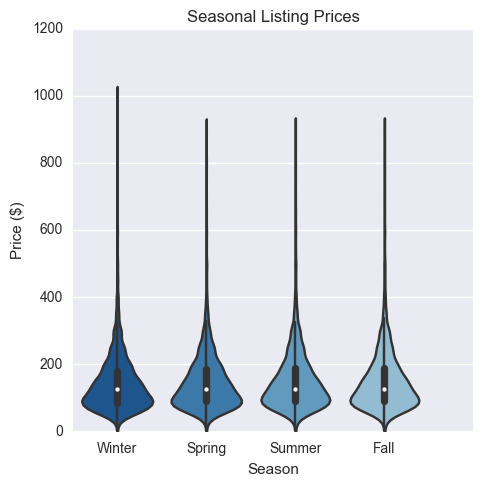

In [42]:
# create a seasonal dataframe with average seasonal pricing for each listing
seasonalDF = calendarDF.groupby ( [ 'listing_id', 'season' ] ) [ 'price' ].mean().to_frame ( name = 'price' ).reset_index()

# parse out the seasonal pricing data
seasons = [ "Winter", "Spring", "Summer", "Fall" ]
df = [ seasonalDF [ "price" ][ ( seasonalDF [ "season" ] == season ) ].values for season in seasons ]

# set up our visualization
sns.set ( rc = { "figure.figsize" : ( 5, 5 ) } )
sns.set_palette ( palette = "Blues_r" )

# create violin plot
ax = sns.violinplot ( data = df )

# set labels
ax.set_title  ( "Seasonal Listing Prices" )
ax.yaxis.grid ( True )
ax.set_xticks ( [ ( y + 1 ) for y in range ( len ( df ) ) ] )
ax.set_xlabel ( "Season" )
ax.set_ylabel ( "Price ($)" )

# add x-tick labels and adjust y-axis
plt.setp (ax, xticks = [ ( y ) for y in range ( len ( df ) ) ], xticklabels = seasons )
ax.set ( ylim = ( 0, None ) )

# display plot
plt.tight_layout()
plt.show()

In milestone #3, we didn’t find any significant seasonality effect on price when looking strictly at the calendar seasons. But we did see price fluctuations and will explore further what might be causing them by looking at other seasonal effects such as holidays, back-to-school, or summer to see if there's a real effect. We'll delve deeper into the potential for seasonal effects from a holiday perspective and/or through interactions (e.g. higher prices around the holidays to accommodate friends and relatives).

#### Visualize Seasonality Trends  
Let's start by only looking at 2015 since we have a few dates in 2016 and some prices that are 0-- we'll filter those out.

In [6]:
# filter out 2016 dates from the calendar listings
calendarDF = calendarDF [ ( calendarDF [ "date" ] < "2016-01-01" ) & ( calendarDF [ "price" ] > 0 ) ]

Next, we'll get the baseline price for each listing, then append it to our original dataset. We'll also get the neighborhood using an inner join which will filter our calendar dataset to one bedroom units as well.

In [7]:
# get the baseline price based on the mode
baselineDF = calendarDF.groupby ( [ 'listing_id' ] ) [ 'price' ].agg (
    lambda x : x.value_counts().index [ 0 ] ).to_frame ( name = 'baseline_price' ).reset_index()

# now add the baseline price to the dataframe
calendarDF = calendarDF.join ( baselineDF.set_index ( "listing_id" ), on = "listing_id" )

# add the neighborhood to the dataframe as well
calendarDF = calendarDF.join ( listingsDF [ [ "neighborhood" ] ], on = "listing_id", how = "inner" )

Now, add the price delta and price delta percent to the dataframe and remove listing dates without a price difference.

In [8]:
# add the price_delta and price_delta_pct
calendarDF [ "price_delta" ]     = ( calendarDF [ "price" ] - calendarDF [ "baseline_price" ] )
calendarDF [ "price_delta_pct" ] = ( 100.0 * ( calendarDF [ "price" ] - calendarDF [ "baseline_price" ] ) / calendarDF [ "baseline_price" ] )

# remove listing dates without a price difference
calendarDF = calendarDF [ calendarDF [ "price_delta_pct" ] != 0 ]

Next, calculate the mean price delta percentage by date and visualize it so we can see if there are any obvious trends.

In [39]:
# get the mean price delta 
pricechangeDF = calendarDF.groupby ( [ 'date' ] ) [ 'price_delta_pct' ].mean().to_frame ( name = 'mean_pct_price_change' ).reset_index()

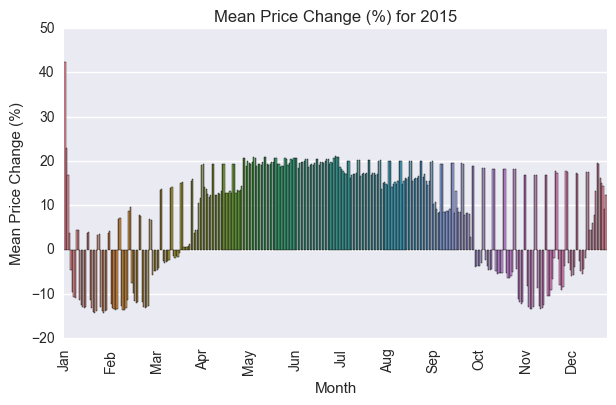

In [40]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 7, 4 ) } )

# plot the histogram of prices - filtering out the extreme highs
ax = sns.barplot ( x = "date", y = "mean_pct_price_change", data = pricechangeDF )

# set the labels
ax.set_title  ( "Mean Price Change (%) for 2015" )
ax.set_xlabel ( "Month" )
ax.set_ylabel ( "Mean Price Change (%)" )
ax.xaxis.set_ticks ( np.arange ( 0, 365, 31 ) )
ax.set_xticklabels ( np.array ( [ 'Jan', 'Feb', 'Mar', 'Apr', 'May'
                                , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ] ), rotation = 90 )

# display the visualization
plt.show()

There are a few seasonality differences we can easily spot from our visualization:
- weekends tend to command a higher price than weekdays
- fall and winter generally have discounted prices compared to spring and summer
- the Christmas and New Years holidays are usually more expensive

Another thing we notice is there seems to be a pattern to the average percent change in price that we might be able to bucket naturally. Again, the reason we choose to go this route is user-friendliness for sellers and buyers in the UI. Let's look at a distribution plot of perecent price differences.

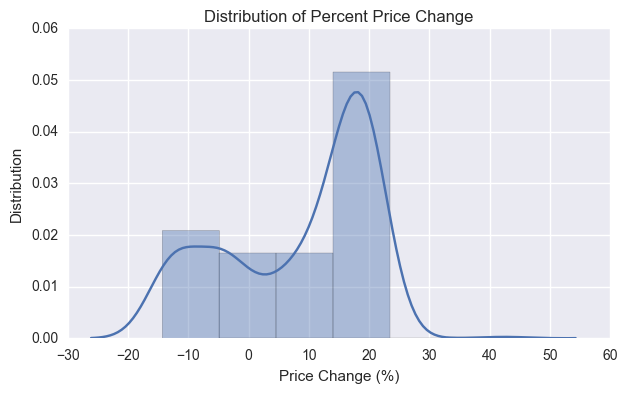

In [69]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 7, 4 ) } )

# plot the histogram of percent price differences
ax = sns.distplot ( pricechangeDF [ "mean_pct_price_change" ], bins = 6 )

# set the labels
ax.set_title  ( "Distribution of Percent Price Change" )
ax.set_xlabel ( "Price Change (%)" )
ax.set_ylabel ( "Distribution" )

#ax.set_xlim ( 0, 1000 )

# display the visualization
plt.show()

To give our model the ability to trend seasonality, we'll add the following date-based features:  
- weekend - 1 for weekend, 0 for weekday
- month - 1-12 for January-December
- new_year_holiday - 1 for New Year's holiday, 0 otherwise
- xmas_holiday - 1 for Christmas holiday, 0 otherwise

In [52]:
# add a weekend indicator to each dataframe
calendarDF    [ "weekend" ] = ( pd.to_datetime (    calendarDF [ "date" ] ).dt.dayofweek >= 5 ) * 1
pricechangeDF [ "weekend" ] = ( pd.to_datetime ( pricechangeDF [ "date" ] ).dt.dayofweek >= 5 ) * 1

# add month feature to each dataframe
calendarDF    [ "month" ] = pd.to_datetime (    calendarDF [ "date" ] ).dt.month
pricechangeDF [ "month" ] = pd.to_datetime ( pricechangeDF [ "date" ] ).dt.month

# add xmas_holiday feature
calendarDF    [ "new_year_holiday" ] = (    calendarDF [ "date" ].str [ 5 : ] <= "01-03" ) * 1
pricechangeDF [ "new_year_holiday" ] = ( pricechangeDF [ "date" ].str [ 5 : ] <= "01-03" ) * 1

# add xmas_holiday feature
calendarDF    [ "xmas_holiday" ] = (    calendarDF [ "date" ].str [ 5 : ] >= "12-24" ) * 1
pricechangeDF [ "xmas_holiday" ] = ( pricechangeDF [ "date" ].str [ 5 : ] >= "12-24" ) * 1